## Creating a spec file with simulated noise. 

Goal: Create a realistic fake noise file that can be read by KTLongSpecProcessor.

TODO: 
* These paths won't work right now. Fix them the next time you wish to make a new noise and gain file for spec_sims. 

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import os 
import sys
import struct 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import numpy as np
import scipy.interpolate as interp 
from scipy.stats import chi2

sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")
from he6_cres_spec_sims.daq.frequency_domain_packet import FDpacket

In [ ]:
## Investigating our noise floor with a colder Noise floor: 

## Creating a new noise file to match the data taken on 4/30/21: (10072021)


In [4]:
path = os.getcwd()
background_file ="/home/drew/He6CRES/CRESAnalysisAndSimulation/SpecFiles/NoiseMeasurement_10152021/Freq_data_2021-10-15-16-31-24.spec"

# October measurement: Freq_data_2021-10-01-16-34-34.spec

# April measurement: Freq_data_2021-04-30-13-12-35.spec
# Create the background to be altered.
freq_bins = 8192
slices_to_grab = 1000
packets_per_slice = 4
background = np.zeros((slices_to_grab*packets_per_slice,freq_bins), dtype = np.uint8)

# open 50K file: 
try: 
    with open(background_file,'rb') as in_file:
        print("Opened .spec noise file.")
        for m in range(slices_to_grab*packets_per_slice):
            c = in_file.read(FDpacket.BYTES_IN_PACKET)
            packet = FDpacket.from_byte_string(c)
            background[m] = packet.interpret_data()
        
except Exception as e:
    raise e

Opened .spec noise file.


In [7]:
start_packet = 0
background_flattened = np.concatenate((background[start_packet%4::4],
                                       background[(start_packet+1)%4::4],
                                       background[(start_packet+2)%4::4],
                                       background[(start_packet+3)%4::4]), axis =1)
# background_150K_flattened = np.concatenate((background_150K[0::4],background_150K[1::4],background_150K[2::4],background_150K[3::4]), axis =1)
pts_in_spline = 100
dev = int(freq_bins*4/pts_in_spline)
print("Select every {}th element in the background_flattened array to do the spline. \n".format(dev))

noise_floor = background_flattened.mean(axis = 0)
# noise_floor_150K = background_150K_flattened.mean(axis = 0)
noise_floor_bins = np.arange(0,noise_floor.shape[0],1)

# Conduct a 300 pt cubic spline fit
noise_floor_cubicspline = interp.CubicSpline(noise_floor_bins[::dev], noise_floor[::dev], extrapolate = True)
# noise_floor_cubicspline_150K = interp.CubicSpline(noise_floor_bins[::dev], noise_floor_150K[::dev], extrapolate = True)

noise_floor_smooth = noise_floor_cubicspline(noise_floor_bins).clip(0)
# noise_floor_smooth_150K = noise_floor_cubicspline_150K(noise_floor_bins).clip(0)

# # Make all negative 

Select every 327th element in the background_flattened array to do the spline. 



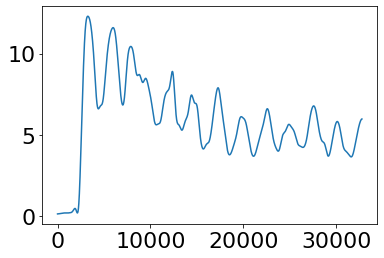

In [8]:
plt.plot(noise_floor_smooth)

In [36]:
path = os.getcwd()
background_file ="/home/drew/He6CRES/CRESAnalysisAndSimulation/SpecFiles/KrTest_04302021/I_side_LessCharged/Freq_data_2021-04-30-13-12-12.spec"

# Create the background to be altered.
freq_bins = 8192
slices_to_grab = 1000
packets_per_slice = 4
background = np.zeros((slices_to_grab*packets_per_slice,freq_bins), dtype = np.uint8)

# open 50K file: 
try: 
    with open(background_file,'rb') as in_file:
        print("Opened .spec noise file.")
        for m in range(slices_to_grab*packets_per_slice):
            c = in_file.read(FDpacket.BYTES_IN_PACKET)
            packet = FDpacket.from_byte_string(c)
            background[m] = packet.interpret_data()
        
except Exception as e:
    raise e

Opened .spec noise file.


In [161]:
start_packet = 1
background_flattened = np.concatenate((background[start_packet%4::4],
                                       background[(start_packet+1)%4::4],
                                       background[(start_packet+2)%4::4],
                                       background[(start_packet+3)%4::4]), axis =1)
# background_150K_flattened = np.concatenate((background_150K[0::4],background_150K[1::4],background_150K[2::4],background_150K[3::4]), axis =1)
pts_in_spline = 100
dev = int(freq_bins*4/pts_in_spline)
print("Select every {}th element in the background_flattened array to do the spline. \n".format(dev))

noise_floor = background_flattened.mean(axis = 0)
# noise_floor_150K = background_150K_flattened.mean(axis = 0)
noise_floor_bins = np.arange(0,noise_floor.shape[0],1)

# Conduct a 300 pt cubic spline fit
noise_floor_cubicspline = interp.CubicSpline(noise_floor_bins[::dev], noise_floor[::dev], extrapolate = True)
# noise_floor_cubicspline_150K = interp.CubicSpline(noise_floor_bins[::dev], noise_floor_150K[::dev], extrapolate = True)

noise_floor_smooth = noise_floor_cubicspline(noise_floor_bins).clip(0)
# noise_floor_smooth_150K = noise_floor_cubicspline_150K(noise_floor_bins).clip(0)

# # Make all negative 

Select every 327th element in the background_flattened array to do the spline. 



In [162]:
plt.plot(noise_floor_smooth)

## Investigating the quality of this simulated noise: 

In [164]:
%matplotlib qt
from numpy.random import default_rng
rng = default_rng(12345)

DOF = 4

background_sim = np.array([rng.chisquare(DOF,background_flattened.shape[0])*mu/DOF for mu in noise_floor_smooth]).transpose()
background_sim = np.around(background_sim, 0)
plt.plot(background_sim.mean(axis =0), label = "simulated")
plt.plot(background_flattened.mean(axis=0), label = "real")
plt.legend()
plt.show()

## Illustrate why this does not work well: 
* One way to do this: 
    * Look at each bin and then divide by the mean, then average across that to get the underlying distribution of the noise. 
    * Hmm what is this showing me?
    

### Real dist

In [174]:
noise_dist_real = []
for i in range(3000,32000,1):
    data = background_flattened[:,i]/background_flattened[:,i].mean()
    noise_dist_real.append(data)
noise_dist_real = np.concatenate( noise_dist_real, axis=0 )
noise_dist_real = noise_dist_real[noise_dist_real<10]

In [154]:
plt.hist(noise_dist_real, bins = 100, alpha = 1)
noise_dist_real.mean()
# print(noise_dist)

1.0000000000000009

### Simulated dist

In [175]:
noise_dist_sim = []
for i in range(3000,32000,1):
    data = background_sim[:,i]/background_sim[:,i].mean()
    noise_dist_sim.append(data)
noise_dist_sim = np.concatenate(noise_dist_sim, axis=0 )
noise_dist_sim = noise_dist_sim[noise_dist_sim<10]

### Comparing them: 

In [182]:
plt.hist(noise_dist_sim, bins = 50, alpha = .5, label = "simulated")
plt.hist(noise_dist_real, bins = 50, alpha = .5, label = "real")
plt.legend()
plt.show()

In [180]:
print("Dist means", noise_dist_sim.mean(), noise_dist_real.mean())
print("Dist stds", noise_dist_sim.std(), noise_dist_real.std())

Dist means 0.9999980367936738 0.9981668582090425
Dist stds 0.8842440738272543 1.1575172125099773


In [120]:
bin = 12000
df = 4

rv = chi2(df)
N = background_flattened[:,bin].sum()
x = np.linspace(chi2.ppf(0.00, df),
                chi2.ppf(0.99, df), 100)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
plt.hist(data, bins = 100, alpha = .5, label = "Real Data", density = True )
plt.legend()
plt.show()

print((rv.pdf(x)).mean())
print(background_flattened[:,bin].mean())

0.0738146198374709
1.324


In [70]:
bin = 5000
plt.hist(np.array(background_sim[:,bin], dtype = "int"), bins = 100, alpha = .5, label = "Simulated Data")
# plt.hist(np.around(background_sim[:,bin],0), bins = 100, alpha = .5, label = "Simulated Data")
plt.hist(background_flattened[:,bin], bins = 100, alpha = .5, label = "Real Data")
plt.legend()
plt.show()

In [86]:
diff_1 = []
diff_2 = []
for i in range(5000,7000,1): 
    diff_1.append(np.histogram(np.array(background_sim[:,bin], dtype = "uint8"), bins = 25)[0] - np.histogram(background_flattened[:,i], bins = 25)[0])
    diff_2.append(np.histogram(np.around(background_sim[:,bin], 0), bins = 25)[0] - np.histogram(background_flattened[:,i], bins = 25)[0])

In [93]:
diff_1 = np.array(diff_1)
diff_2 = np.array(diff_2)


plt.plot(diff_2.mean(axis =0))
plt.plot(diff_1.mean(axis =0))

In [98]:
plt.plot(background_sim.mean(axis =1))
plt.plot(background_flattened.mean(axis =1))

print(background_sim.mean(axis =1).mean())
print(background_flattened.mean(axis =1).mean())

0.8727750003795708
0.86902734375


## Write the simulated noise file to the he6-cres-spec-sims repo 
To be used in spec file creation. 

In [92]:
results_dir = "/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/gain_noise_measurements/"

exists = os.path.isdir(results_dir)
print(exists)


# If folder doesn't exist, then create it.
if not exists:

    print("DNE: ", results_dir)

try:
    gain_file_path = results_dir + "gain.csv"
    noise_file_path = results_dir + "noise.csv"
    
#     pd.DataFrame(noise_floor_smooth).to_csv(gain_file_path,header=None, index=None)
#     pd.DataFrame(noise_floor_smooth).to_csv(noise_file_path,header=None, index=None)
    
    np.savetxt(gain_file_path, noise_floor_smooth*50*1e15, delimiter = ",")
    np.savetxt(noise_file_path, noise_floor_smooth, delimiter = ",")
    
except Exception as e:
    print("Unable to open df.")
    raise e

True


## Creating a fake spec file with simulated noise: 

### First open a noise file and make a spline of the noise floor : 

In [14]:

path = os.getcwd()
background_file_50K = "/home/drew/He6CRES/CRESAnalysisAndSimulation/SpecFiles/NoiseMeasurement_10012021/Freq_data_2021-10-01-16-34-34.spec"
background_file_150K = "/home/drew/He6CRES/CRESAnalysisAndSimulation/SpecFiles/KrTest_04302021/I_side_LessCharged/Freq_data_2021-04-30-13-12-35.spec"

# Create the background to be altered.
freq_bins = 8192
slices_to_grab = 400
packets_per_slice = 4
background_50K = np.zeros((slices_to_grab*packets_per_slice,freq_bins), dtype = np.uint8)
background_150K = np.zeros((slices_to_grab*packets_per_slice,freq_bins), dtype = np.uint8)

# open 50K file: 
try: 
    with open(background_file_50K,'rb') as in_file:
        print("Opened .spec noise file.")
        for m in range(slices_to_grab*packets_per_slice):
            c = in_file.read(FDpacket.BYTES_IN_PACKET)
            packet = FDpacket.from_byte_string(c)
            background_50K[m] = packet.interpret_data()
        
except Exception as e:
    raise e
    
# open 150K file: 
try: 
    with open(background_file_150K,'rb') as in_file:
        print("Opened .spec noise file.")
        for m in range(slices_to_grab*packets_per_slice):
            c = in_file.read(FDpacket.BYTES_IN_PACKET)
            packet = FDpacket.from_byte_string(c)
            background_150K[m] = packet.interpret_data()
        
except Exception as e:
    raise e

Opened .spec noise file.
Opened .spec noise file.


### Flatten the background file so its shape corresponds to a power spectrogram

In [38]:
background_50K_flattened = np.concatenate((background_50K[0::4],background_50K[1::4],background_50K[2::4],background_50K[3::4]), axis =1)
background_150K_flattened = np.concatenate((background_150K[0::4],background_150K[1::4],background_150K[2::4],background_150K[3::4]), axis =1)
pts_in_spline = 200
dev = int(freq_bins*4/pts_in_spline)
print("Select every {}th element in the background_flattened array to do the spline. \n".format(dev))

noise_floor_50K = background_50K_flattened.mean(axis = 0)
noise_floor_150K = background_150K_flattened.mean(axis = 0)
noise_floor_bins = np.arange(0,noise_floor_50K.shape[0],1)

# Conduct a 300 pt cubic spline fit
noise_floor_cubicspline_50K = interp.CubicSpline(noise_floor_bins[::dev], noise_floor_50K[::dev], extrapolate = True)
noise_floor_cubicspline_150K = interp.CubicSpline(noise_floor_bins[::dev], noise_floor_150K[::dev], extrapolate = True)

noise_floor_smooth_50K = noise_floor_cubicspline_50K(noise_floor_bins).clip(0)
noise_floor_smooth_150K = noise_floor_cubicspline_150K(noise_floor_bins).clip(0)

# # Make all negative noise powers 0:
# noise_floor_smooth = noise_floor_smooth.clip(0)

Select every 163th element in the background_flattened array to do the spline. 



In [59]:
%matplotlib qt
noise_floor_freq = noise_floor_bins*1200/noise_floor_bins.shape[0]

# Conduct a 300 pt cubic spline fit
plt.plot(noise_floor_freq,noise_floor_smooth_50K/8, label = "decay cell @ T = 52 K")
plt.plot(noise_floor_freq,noise_floor_smooth_150K, label = "decay cell @ T = 133 K")
plt.title("Noise Floor (requant gain = 17)")
plt.xlabel("Freq (MHz)")
plt.ylabel("Power (arb.)")
plt.legend()
plt.show()

In [63]:
difference = (noise_floor_smooth_150K - noise_floor_smooth_50K/8)/(noise_floor_smooth_50K/8)
# diff_2 = (noise_floor_smooth_150K/(noise_floor_smooth_50K/8))
plt.plot(noise_floor_freq,difference)
plt.plot(noise_floor_freq,np.ones_like(noise_floor_bins)*difference[2731:].mean(), label = "Mean Relative Diff = {}$\%$ "
         .format(np.around(difference[2731:].mean(),3)*100 ))
plt.title("Relative Difference in Noise Power (requant gain = 17)")
plt.xlabel("Freq (MHz)")
plt.ylabel("Power (arb.)")
plt.show()
plt.legend()
# print(diff_2[2731:].mean())

inf


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/ipykernel/eventloops.py:106: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.exec_()


### SAVE: Writing the noise_floor_smooth to a csv to be used by the simulation.
* The same will go for the gain. 
* For now I'll just write the gain in the same way.

In [87]:
results_dir = "{}/he6_cres_spec_sims/spec_tools/gain_noise_measurements/".format(os.getcwd())

exists = os.path.isdir(results_dir)
print(exists)


# If folder doesn't exist, then create it.
if not exists:

    print("DNE: ", results_dir)

try:
    gain_file_path = results_dir + "gain.csv"
    noise_file_path = results_dir + "noise.csv"
    
#     pd.DataFrame(noise_floor_smooth).to_csv(gain_file_path,header=None, index=None)
#     pd.DataFrame(noise_floor_smooth).to_csv(noise_file_path,header=None, index=None)
    
    np.savetxt(gain_file_path, noise_floor_smooth*50*1e15, delimiter = ",")
    np.savetxt(noise_file_path, noise_floor_smooth, delimiter = ",")
    
except Exception as e:
    print("Unable to open df.")
    raise e

True


In [88]:
# Now how to open: 

results_dir = "{}/he6_cres_spec_sims/spec_tools/gain_noise_measurements/".format(os.getcwd())

exists = os.path.isdir(results_dir)

if not exists:

    print("Path to directory ({}) doesn't exist ".format(results_dir))

try:
    gain_file_path = results_dir + "gain.csv"
    noise_file_path = results_dir + "noise.csv"

    gain = np.loadtxt(gain_file_path, delimiter=",")
    noise = np.loadtxt(noise_file_path, delimiter=",")

except Exception as e:
    print("Unable to open df.")
    raise e

plt.plot(gain)
plt.plot(noise)

### Show that the simulated background makes sense

In [72]:
from numpy.random import default_rng
rng = default_rng(12345)

DOF = 4
mu = 10
# print((rng.chisquare(DOF,10000)*mu/DOF).mean())


# # With exponential (technichally not correct. Note that chisq with DOF = 2 corresponds to an exponential.)
# background_sim = np.array([np.random.exponential(mu,background_flattened.shape[0]) for mu in noise_floor_smooth]).transpose()

# With chisq dist DOF = 4: 
DOF = 4

background_sim = np.array([rng.chisquare(DOF,background_flattened.shape[0])*mu/DOF for mu in noise_floor_smooth]).transpose()
plt.plot(background_sim.sum(axis =0))
plt.show()
plt.plot(background_flattened.sum(axis = 0))
plt.show()

plt.plot(background_flattened.sum(axis = 0)-background_sim.sum(axis = 0))
plt.show()



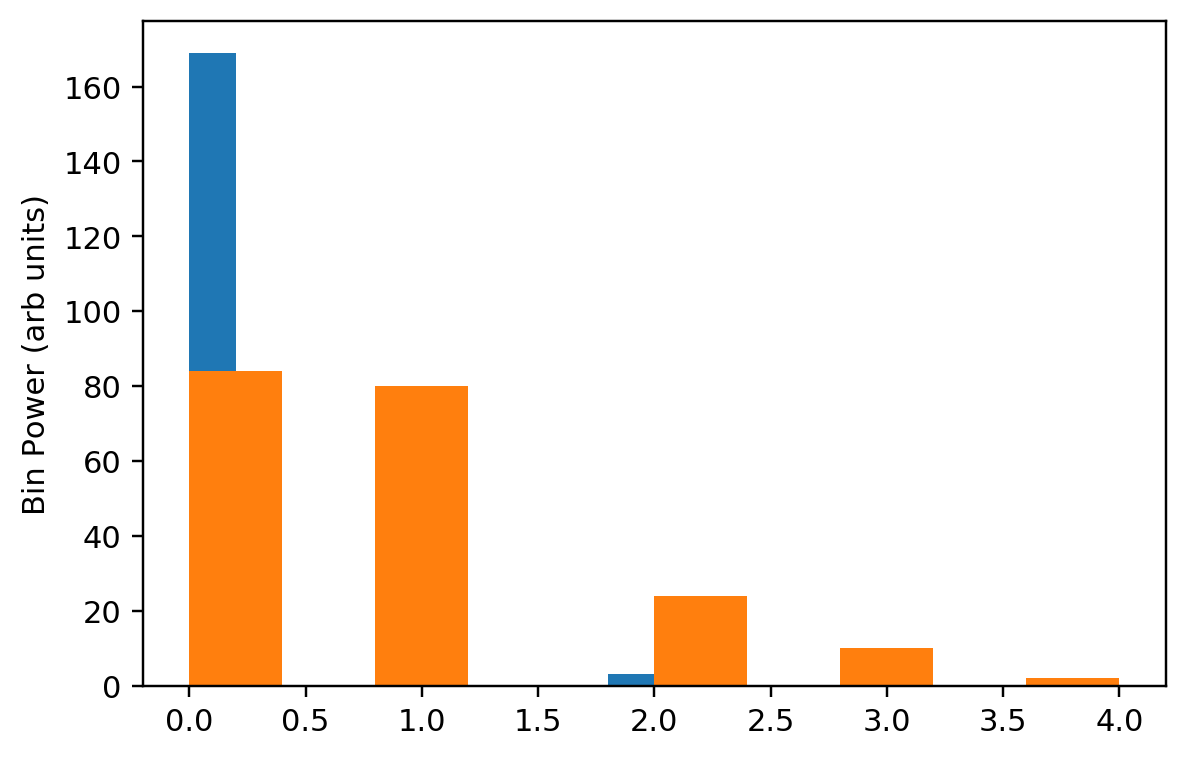

In [26]:
# Compare a slice: 
# Figure out why this doesn't make sense. 
plt.ylabel("Bin Power (arb units)")
plt.hist(background_sim[:,25000].astype("uint8"), bins = 10)
plt.hist(background_flattened[:,25000], bins = 10)
plt.show()

### Now grab the headers that correspond to the 4 packets that make up the frequency spectrum. 

In [179]:
# Grab the headers for the 4 differnt packets (0,1,2,3): 
path = os.getcwd()
background_file = path + '/he6_cres_spec_sims/spec_tools/roach_noise/Freq_data_2021-04-30-13-14-18.spec'
# open file: 
hdr_list = []
try: 
    with open(background_file,'rb') as in_file:
        print("Opened roach_noise file.")
        for m in range(4):          
            hdr = in_file.read(FDpacket.BYTES_IN_HEADER)
            hdr_list.append(hdr)           
            data = in_file.read(FDpacket.BYTES_IN_PAYLOAD)

except Exception as e:
    raise e

Opened roach_noise file.


### Now use these headers and the spline fit to make a spec file of arbitrary many slices: 

In [17]:
# Make arbitrarily large spec file: 
slices_in_spec = 1200
background_sim = np.array([np.random.exponential(mu,slices_in_spec) for mu in noise_floor_smooth]).transpose()
print(background_sim.shape, test_data.shape)
# Alter the background_sim for kicks: 
# background_sim[:,10000:20000] = 50
# Now write the new background file to a spec file:
spec_test_label = 2
output_file = "/home/drew/He6CRES/CRESAnalysisAndSimulation/SpecFiles/Simulated/TEST_{}.spec".format(spec_test_label)

# Pass "wb" to write a binary file
with open(output_file, "wb") as out_file:

    # Loop over slices in spec file
    for a in range(slices_in_spec*4):
        
        packet_num = a%4 
        slice_num = a //4 
        
        # Testing new data: 
        data = test_data[slice_num][int(packet_num*freq_bins):int((packet_num+1)*freq_bins)]/10
        
        data = data +  background_sim[slice_num][int(packet_num*freq_bins):int((packet_num+1)*freq_bins)]
        data = data.astype('uint8')
        out_file.write(hdr_list[a%4]) 
        data.tofile(out_file)

(1200, 32768) (1200, 32768)


### Now check to see that this worked: 

In [305]:
# open file: 
try: 
    with open(output_file,'rb') as in_file:
        print("Opened roach_noise file.")
        for m in range(slices_in_spec*4):
#             print(m)
            c = in_file.read(FDpacket.BYTES_IN_PACKET)
            packet = FDpacket.from_byte_string(c)

            background[m] = packet.interpret_data()
        
except Exception as e:
    raise e

Opened roach_noise file.


IndexError: index 800 is out of bounds for axis 0 with size 800

### Plot the spec file to see that things are being pieced back togehter well:

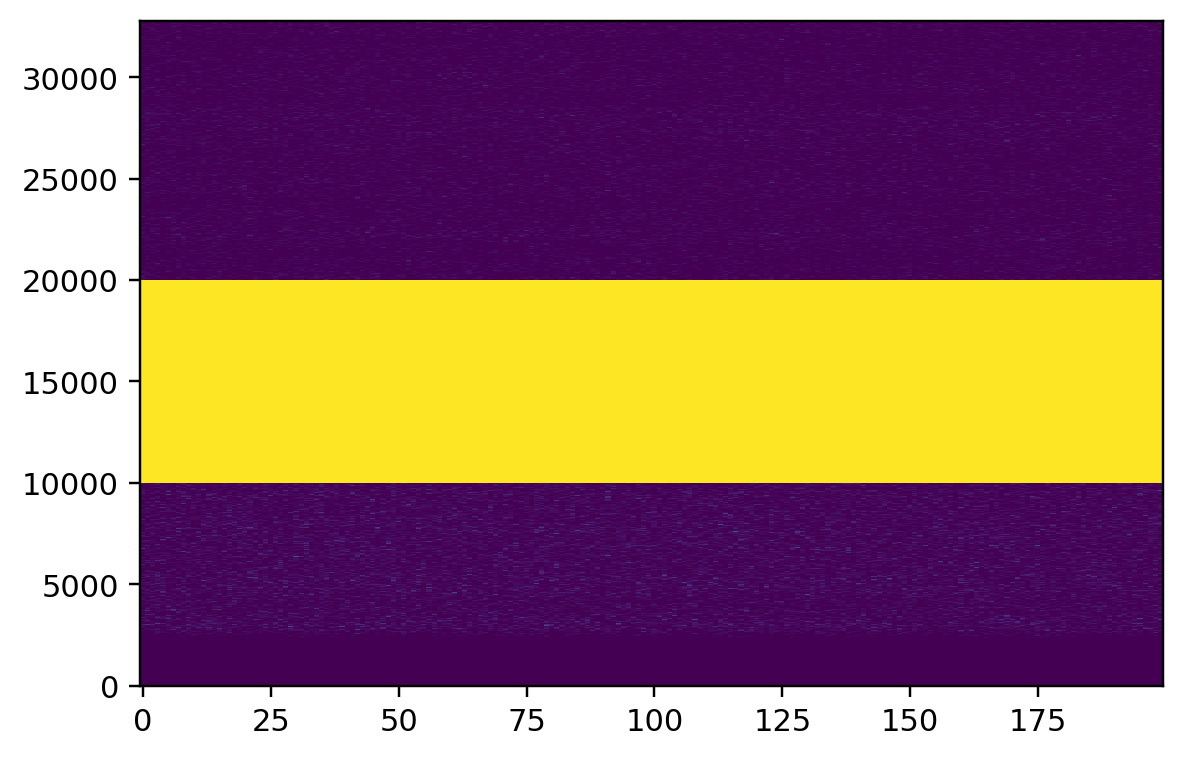

In [41]:
background_flattened = np.concatenate((background[0::4],background[1::4],background[2::4],background[3::4]), axis =1)

plt.imshow(background_flattened.T, aspect='auto',origin='lower' )